## Object-Oriented Approach to Digit Recognition

After achieving an accuracy of 89% on the test set, we can confidently state that our model performs well enough for practical use. However, testing its performance in real-world scenarios is crucial to ensure its robustness and reliability.

To achieve this, we will encapsulate the digit recognition process within a Python class. This object-oriented approach allows us to organize the functionality into a reusable and modular structure. Additionally, we will conduct various experiments to evaluate how the model behaves under different conditions and test cases.

### Goals of This Implementation

- **Evaluate Model Performance**: Test the model's accuracy and reliability in diverse scenarios.
- **Experiment with Variations**: Assess how the model handles different inputs, including noisy or distorted digits.
- **Identify Areas for Improvement**: Analyze results to uncover potential enhancements for the model.

By structuring our implementation as a class, we ensure that the digit recognition pipeline is clean, maintainable, and extensible for future improvements.

In [74]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
from rich.console import Console
from time import time
import logging

In [75]:
console = Console()

## Digit Recognition Class

In [76]:
class DigitClassification:
    """
    Classifies digits using Gaussian Mixture Models (GMM) with KMeans or Expectation-Maximization (EM).
    """

    def __init__(
        self,
        n_components: int,
        method: str = "kmeans",
        covariance_type: str = "full",
        digits: list[int] = None,
        info_persistent: bool = False,
    ):
        """
        Initialize the DigitClassification class.

        :param n_components: Number of components/clusters for GMM.
        :param method: Clustering method ('kmeans' or 'em').
        :param covariance_type: Covariance type for GMM ('full', 'tied', 'diag', 'spherical').
        :param digits: Digits to classify (default: all digits from 0 to 9).
        """
        self.method = method
        self.covariance_type = covariance_type
        self.n_components = [n_components] * 10
        self.digits = digits or list(range(10))
        self.models: list[GaussianMixture] = []
        self.info_persistent = info_persistent

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Fit the GMM models for each digit.

        :param X_train: Training data.
        :param y_train: Training labels.
        """
        print(
            f"Training GMM - {self.method} method | {self.covariance_type} covariance type | "
            f"{self.n_components[0]} components | {len(X_train)} samples"
        )
        for digit in tqdm(self.digits, desc="Fitting digits in GMM", colour="green", leave=self.info_persistent, position=0, disable=not self.info_persistent, dynamic_ncols=True):
            X_digit = X_train[y_train == digit]
            if self.method == "kmeans":
                self._gmm_kmeans_fitting(X_digit, digit)
            elif self.method == "em":
                self._gmm_em_fitting(X_digit, digit)
            else:
                raise ValueError(f"Invalid method: {self.method}")

    def _gmm_em_fitting(self, X: np.ndarray, digit: int) -> None:
        """
        Fit the GMM model using the EM algorithm.

        :param X: Data to fit.
        :param digit: The digit being processed.
        """
        
        mfccs = np.vstack(X)
        
        gmm = GaussianMixture(
            n_components=self.n_components[digit], covariance_type=self.covariance_type
        )
        gmm.fit(mfccs)
        self.models.append(gmm)

    def _gmm_kmeans_fitting(self, X: np.ndarray, digit: int) -> None:
        """
        Fit the GMM model using KMeans.

        :param X: Data to fit.
        :param digit: The digit being processed.
        """
        model = KMeans(n_clusters=self.n_components[digit])
        mfccs = np.vstack(X)

        model.fit(mfccs)
        cluster_labels = model.labels_

        weights, means, covariances = [], [], []

        if self.covariance_type == "tied":
            mfccs_centered = mfccs - np.mean(mfccs, axis=0)
            tied_cov = np.cov(mfccs_centered, rowvar=False)

        for cluster in range(self.n_components[digit]):
            cluster_mfccs = mfccs[cluster_labels == cluster]
            if not len(cluster_mfccs):
                raise ValueError(f"No data points in cluster {cluster}.")

            weights.append(len(cluster_mfccs) / len(mfccs))
            means.append(np.mean(cluster_mfccs, axis=0))

            if self.covariance_type == "full":
                covariances.append(np.cov(cluster_mfccs, rowvar=False))
            elif self.covariance_type == "tied":
                covariances.append(tied_cov)
            elif self.covariance_type == "diag":
                covariances.append(np.diag(np.var(cluster_mfccs, axis=0)))
            elif self.covariance_type == "spherical":
                covariances.append(np.var(cluster_mfccs))
            else:
                raise ValueError(f"Invalid covariance type: {self.covariance_type}")

        gmm = GaussianMixture(
            n_components=self.n_components[digit], covariance_type=self.covariance_type
        )
        gmm.weights_ = np.array(weights)
        gmm.means_ = np.array(means)
        gmm.covariances_ = np.array(covariances) if self.covariance_type != "tied" else tied_cov
        gmm.precisions_cholesky_ = _compute_precision_cholesky(
            gmm.covariances_, self.covariance_type
        )
        self.models.append(gmm)

    def predict(self, X_test: list[np.ndarray]) -> np.ndarray:
        """
        Predict the digit for each test sample.

        :param X_test: Test samples.
        :return: Array of predicted digits.
        """
        predictions = []
        for mfccs in tqdm(X_test, desc="Predicting digits with GMM", colour="green", leave=self.info_persistent, position=0, disable=not self.info_persistent, dynamic_ncols=True):
            likelihoods = [model.score_samples(mfccs).sum() for model in self.models]
            predictions.append(np.argmax(likelihoods))
        return np.array(predictions)

    def evaluate(self, X_test: list[np.ndarray], y_test: np.ndarray) -> tuple[float, np.ndarray]:
        """
        Evaluate the model on test data.

        :param X_test: Test samples.
        :param y_test: True labels.
        :return: Accuracy and confusion matrix.
        """
        predictions = self.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        cm = confusion_matrix(y_test, predictions)
        return accuracy, cm

    def compute_cost(
        self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray
    ) -> tuple[float, float]:
        """
        Compute training and prediction time.

        :param X_train: Training data.
        :param y_train: Training labels.
        :param X_test: Test data.
        :param y_test: Test labels.
        :return: Training and prediction time.
        """
        start = time.time()
        self.fit(X_train, y_train)
        training_time = time.time() - start

        start = time.time()
        self.predict(X_test)
        prediction_time = time.time() - start

        return training_time, prediction_time


### Example Usage

In [77]:
# example usage
df_train = pd.read_csv('../data/train_grouped.csv')
df_test = pd.read_csv('../data/test_grouped.csv')

X_train = df_train['coefficients'].apply(lambda x: np.array(eval(x)))
y_train = df_train['digit'].values

X_test = df_test['coefficients'].apply(lambda x: np.array(eval(x)))
y_test = df_test['digit'].values

#### Kmeans

In [78]:
dc = DigitClassification(5, method='kmeans')
dc.fit(X_train, y_train)

Training GMM - kmeans method | full covariance type | 5 components | 6600 samples


In [79]:
dc.predict(X_test)

array([0, 0, 0, ..., 7, 9, 6])

Accuracy: 0.8586363636363636


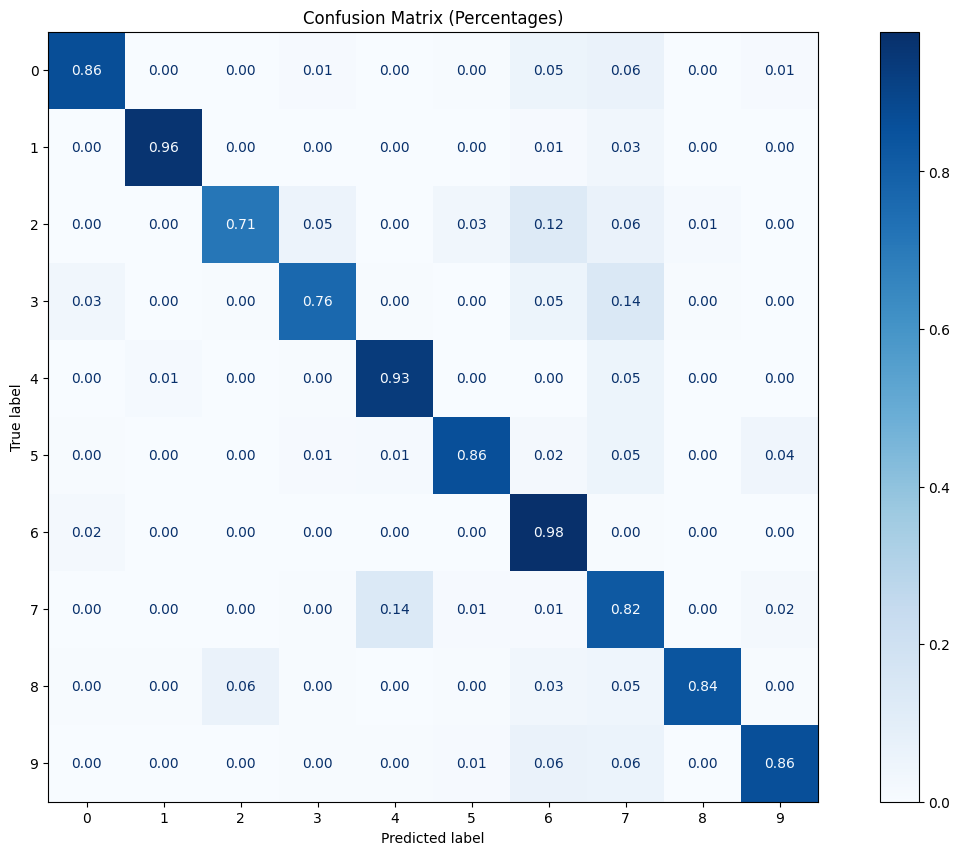

In [80]:
acc, cm = dc.evaluate(X_test, y_test)
print(f"Accuracy: {acc}")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (percentages)

# ------------------- Display Confusion Matrix -------------------
fig, ax = plt.subplots(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[str(i) for i in range(10)])
disp.plot(values_format=".2f", ax=ax, cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.show()

#### Estimation-Maximization

In [81]:
dc = DigitClassification(5, method='em')
dc.fit(X_train, y_train)

Training GMM - em method | full covariance type | 5 components | 6600 samples


In [82]:
dc.predict(X_test)

array([0, 0, 0, ..., 9, 9, 6])

Accuracy: 0.8977272727272727


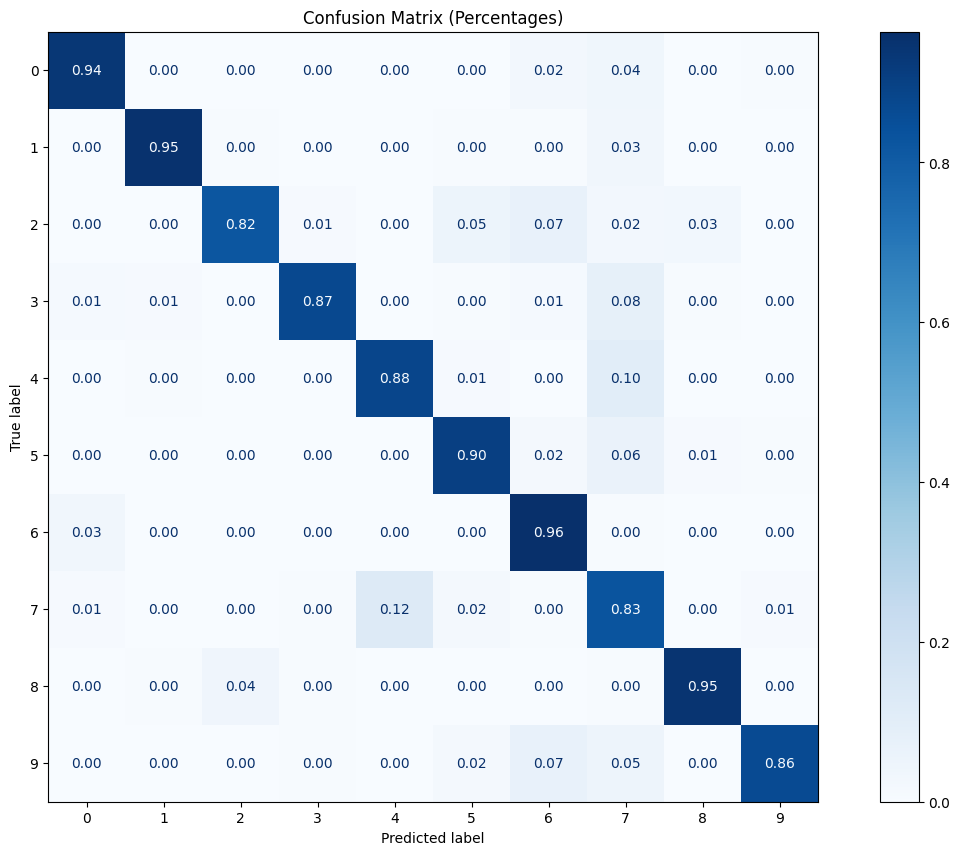

In [83]:
acc, cm = dc.evaluate(X_test, y_test)
print(f"Accuracy: {acc}")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (percentages)

# ------------------- Display Confusion Matrix -------------------
fig, ax = plt.subplots(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[str(i) for i in range(10)])
disp.plot(values_format=".2f", ax=ax, cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.show()

## Experiment comparing EM and Kmeans initialization of GMM for digit recognition

In [84]:
covariance_types = ['full', 'tied', 'diag', 'spherical']
methods = ['kmeans', 'em']
iterations = [1, 5, 10, 20, 50, 100]
n_components = 7

In [85]:
# Initialize logging
logging.basicConfig(filename="training_errors.log", level=logging.ERROR)

In [86]:
# Initialize a dictionary to store results
results = {
    "Covariance": [],
    "Method": [],
    "Iteration": [],
    "Accuracy": []
}

Covariance Type:   0%|          | 0/4 [00:00<?, ?it/s]

Method:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - kmeans method | full covariance type | 7 components | 6600 samples
Training GMM - kmeans method | full covariance type | 7 components | 6600 samples
Training GMM - kmeans method | full covariance type | 7 components | 6600 samples
Training GMM - kmeans method | full covariance type | 7 components | 6600 samples
Training GMM - kmeans method | full covariance type | 7 components | 6600 samples
Training GMM - kmeans method | full covariance type | 7 components | 6600 samples


Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - em method | full covariance type | 7 components | 6600 samples
Training GMM - em method | full covariance type | 7 components | 6600 samples
Training GMM - em method | full covariance type | 7 components | 6600 samples
Training GMM - em method | full covariance type | 7 components | 6600 samples
Training GMM - em method | full covariance type | 7 components | 6600 samples
Training GMM - em method | full covariance type | 7 components | 6600 samples


Method:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - kmeans method | tied covariance type | 7 components | 6600 samples
Training GMM - kmeans method | tied covariance type | 7 components | 6600 samples
Training GMM - kmeans method | tied covariance type | 7 components | 6600 samples
Training GMM - kmeans method | tied covariance type | 7 components | 6600 samples
Training GMM - kmeans method | tied covariance type | 7 components | 6600 samples
Training GMM - kmeans method | tied covariance type | 7 components | 6600 samples


Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - em method | tied covariance type | 7 components | 6600 samples
Training GMM - em method | tied covariance type | 7 components | 6600 samples
Training GMM - em method | tied covariance type | 7 components | 6600 samples
Training GMM - em method | tied covariance type | 7 components | 6600 samples
Training GMM - em method | tied covariance type | 7 components | 6600 samples
Training GMM - em method | tied covariance type | 7 components | 6600 samples


Method:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - kmeans method | diag covariance type | 7 components | 6600 samples
Training GMM - kmeans method | diag covariance type | 7 components | 6600 samples
Training GMM - kmeans method | diag covariance type | 7 components | 6600 samples
Training GMM - kmeans method | diag covariance type | 7 components | 6600 samples
Training GMM - kmeans method | diag covariance type | 7 components | 6600 samples
Training GMM - kmeans method | diag covariance type | 7 components | 6600 samples


Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - em method | diag covariance type | 7 components | 6600 samples
Training GMM - em method | diag covariance type | 7 components | 6600 samples
Training GMM - em method | diag covariance type | 7 components | 6600 samples
Training GMM - em method | diag covariance type | 7 components | 6600 samples
Training GMM - em method | diag covariance type | 7 components | 6600 samples
Training GMM - em method | diag covariance type | 7 components | 6600 samples


Method:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - kmeans method | spherical covariance type | 7 components | 6600 samples
Training GMM - kmeans method | spherical covariance type | 7 components | 6600 samples
Training GMM - kmeans method | spherical covariance type | 7 components | 6600 samples
Training GMM - kmeans method | spherical covariance type | 7 components | 6600 samples
Training GMM - kmeans method | spherical covariance type | 7 components | 6600 samples
Training GMM - kmeans method | spherical covariance type | 7 components | 6600 samples


Iterations:   0%|          | 0/6 [00:00<?, ?it/s]

Training GMM - em method | spherical covariance type | 7 components | 6600 samples
Training GMM - em method | spherical covariance type | 7 components | 6600 samples
Training GMM - em method | spherical covariance type | 7 components | 6600 samples
Training GMM - em method | spherical covariance type | 7 components | 6600 samples
Training GMM - em method | spherical covariance type | 7 components | 6600 samples
Training GMM - em method | spherical covariance type | 7 components | 6600 samples


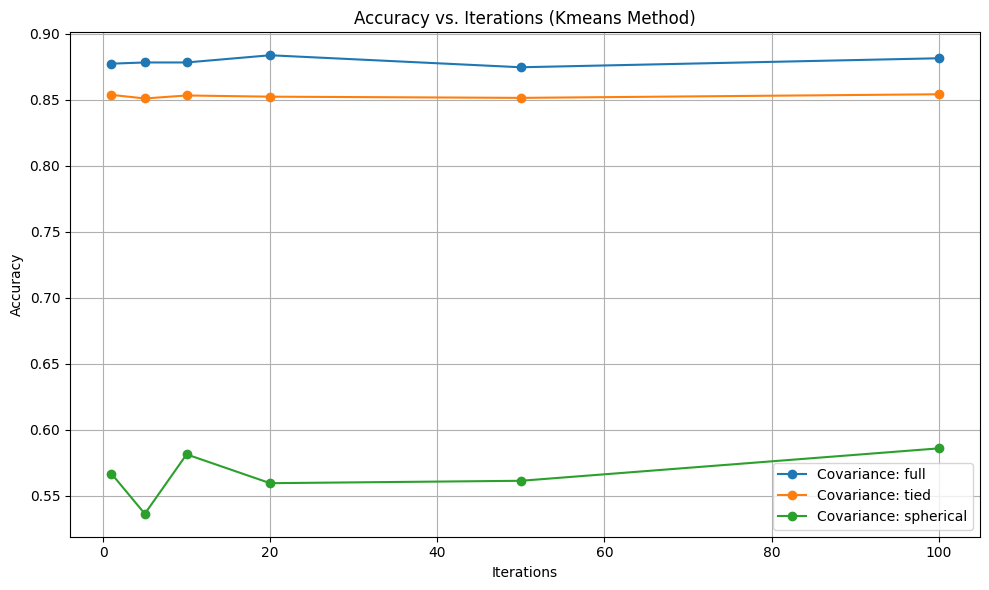

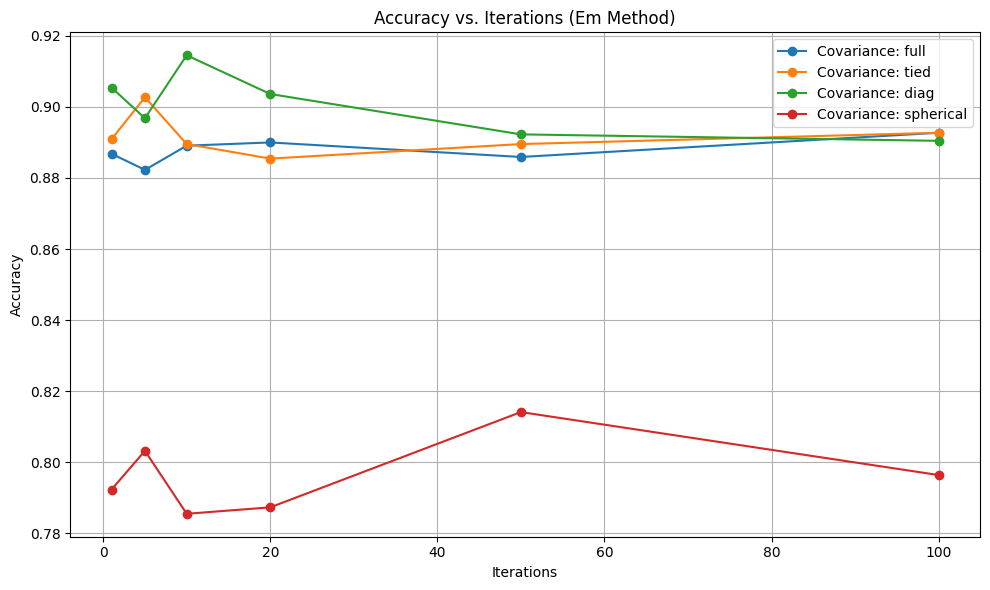

In [87]:
# Initialize logging
logging.basicConfig(filename="training_errors.log", level=logging.ERROR)

# Initialize a dictionary to store results
results = {
    "Covariance": [],
    "Method": [],
    "Iteration": [],
    "Accuracy": []
}

# Prepare data for plotting
plot_data = {method: {cov: [] for cov in covariance_types} for method in methods}

# Loop through configurations
for cov in tqdm(covariance_types, desc="Covariance Type"):
    for method in tqdm(methods, desc="Method", leave=False):
        accuracies = []
        for n in tqdm(iterations, desc="Iterations", leave=False):
            try:
                # Initialize and train model
                dc = DigitClassification(n_components=n_components, method=method, covariance_type=cov)
                dc.fit(X_train, y_train)

                # Evaluate model
                acc, cm = dc.evaluate(X_test, y_test)
                accuracies.append(acc)

                # Save results
                results["Covariance"].append(cov)
                results["Method"].append(method)
                results["Iteration"].append(n)
                results["Accuracy"].append(acc)

            except ValueError as e:
                logging.error(f"Error for Covariance={cov}, Method={method}, Iteration={n}: {e}")
                continue

        # Store accuracies for plotting later
        plot_data[method][cov] = accuracies

# Generate plots
for method in methods:
    plt.figure(figsize=(10, 6))
    for cov in covariance_types:
        accuracies = plot_data[method][cov]
        if accuracies:  # Ensure that accuracies list is not empty
            plt.plot(iterations[:len(accuracies)], accuracies, marker="o", label=f"Covariance: {cov}")
        else:
            logging.warning(f"No valid results for Method={method}, Covariance={cov}. Skipping.")

    plt.title(f"Accuracy vs. Iterations ({method.capitalize()} Method)")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Experiment with different covariances types